In [10]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

In [11]:
def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()


def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg'):
    display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), 'constant')
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a


def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


class VideoWriter:
    def __init__(self, filename, fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()


In [12]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 8   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 256
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [13]:
from tensorflow.keras.layers import Conv2D


def load_image(url, max_size=TARGET_SIZE):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png' % code
    return load_image(url)


def to_rgba(x):
    return x[..., :4]


def to_alpha(x):
    return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)


def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return 1.0 - a + rgb


def get_living_mask(x):
    alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


def make_seed(size, n=1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size // 2, size // 2, 3:] = 1.0
    return x


class CAModel(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        self.dmodel = tf.keras.Sequential([
            Conv2D(32, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=None,
                   kernel_initializer=tf.zeros_initializer),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    @tf.function
    def perceive(self, x, angle=0.0):
        identify = np.float32([0, 1, 0])
        identify = np.outer(identify, identify)
        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c, s = tf.cos(angle), tf.sin(angle)
        kernel = tf.stack([identify, c * dx - s * dy, s * dx + c * dy], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)
        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x, angle)
        dx = self.dmodel(y) * step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)



In [14]:
CAModel().dmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (1, 3, 3, 32)             416       
_________________________________________________________________
conv2d_3 (Conv2D)            (1, 3, 3, 4)              132       
Total params: 548
Trainable params: 548
Non-trainable params: 0
_________________________________________________________________


In [15]:

# @title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants


class SamplePool:
    def __init__(self, *, _parent=None, _parent_idx=None, **slots):
        self._parent = _parent
        self._parent_idx = _parent_idx
        self._slot_names = slots.keys()
        self._size = None
        for k, v in slots.items():
            if self._size is None:
                self._size = len(v)
            assert self._size == len(v)
            setattr(self, k, np.asarray(v))

    def sample(self, n):
        idx = np.random.choice(self._size, n, False)
        batch = {k: getattr(self, k)[idx] for k in self._slot_names}
        batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
        return batch

    def commit(self):
        for k in self._slot_names:
            getattr(self._parent, k)[self._parent_idx] = getattr(self, k)


@tf.function
def make_circle_masks(n, h, w):
    x = tf.linspace(-1.0, 1.0, w)[None, None, :]
    y = tf.linspace(-1.0, 1.0, h)[None, :, None]
    center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
    r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
    x, y = (x - center[0]) / r, (y - center[1]) / r
    mask = tf.cast(x * x + y * y < 1.0, tf.float32)
    return mask


def export_model(ca, base_fn):
    ca.save_weights(base_fn)

    cf = ca.call.get_concrete_function(
        x=tf.TensorSpec([None, None, None, CHANNEL_N]),
        fire_rate=tf.constant(0.5),
        angle=tf.constant(0.0),
        step_size=tf.constant(1.0))
    cf = convert_to_constants.convert_variables_to_constants_v2(cf)
    graph_def = cf.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
    model_json = {
        'format': 'graph-model',
        'modelTopology': graph_json,
        'weightsManifest': [],
    }
    with open(base_fn + '.json', 'w') as f:
        json.dump(model_json, f)


def generate_pool_figures(pool, step_i):
    tiled_pool = tile2d(to_rgb(pool.x[:49]))
    fade = np.linspace(1.0, 0.0, 72)
    ones = np.ones(72)
    tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
    tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
    tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
    tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
    imwrite('train_log/%04d_pool.jpg' % step_i, tiled_pool)


def visualize_batch(x0, x, step_i):
    vis0 = np.hstack(to_rgb(x0).numpy())
    vis1 = np.hstack(to_rgb(x).numpy())
    vis = np.vstack([vis0, vis1])
    imwrite('train_log/batches_%04d.jpg' % step_i, vis)
    print('batch (before/after):')
    imshow(vis)


def plot_loss(loss_log):
    pl.figure(figsize=(10, 4))
    pl.title('Loss history (log10)')
    pl.plot(np.log10(loss_log), '.', alpha=0.1)
    pl.show()


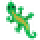

In [16]:
#@title Choose Target Image { vertical-output: true}
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [18]:
#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
    return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

batch (before/after):


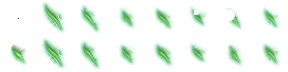

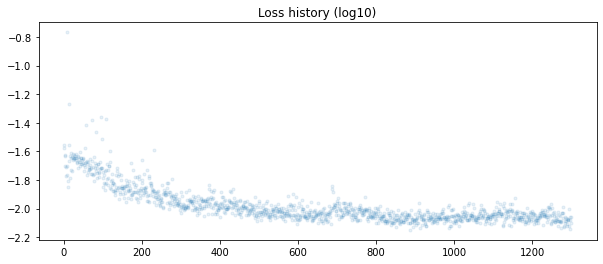

 step: 1323, log10(loss): -2.055

KeyboardInterrupt: 

In [19]:
@tf.function
def train_step(x):
    iter_n = tf.random.uniform([], 64, 96, tf.int32)
    with tf.GradientTape() as g:
        for i in tf.range(iter_n):
            x = ca(x)
        loss = tf.reduce_mean(loss_f(x))
    grads = g.gradient(loss, ca.weights)
    grads = [g / (tf.norm(g) + 1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))
    return x, loss


for i in range(8000 + 1):
    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = batch.x
        loss_rank = loss_f(x0).numpy().argsort()[::-1]
        x0 = x0[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0 - make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

    x, loss = train_step(x0)

    if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i % 10 == 0:
        generate_pool_figures(pool, step_i)
    if step_i % 100 == 0:
        clear_output()
        visualize_batch(x0, x, step_i)
        plot_loss(loss_log)
        export_model(ca, 'train_log/%04d' % step_i)

    print('\r step: %d, log10(loss): %.3f' % (len(loss_log), np.log10(loss)), end='')


In [ ]:
models = []
for i in [100, 500, 1000, 4000]:
    ca = CAModel()
    ca.load_weights('train_log/%04d'%i)
    models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
    for i in tqdm.trange(500):
        vis = np.hstack(to_rgb(x))
        vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
        xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

In [ ]:
#@title Pool Contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

In [ ]:
!wget -O models.zip 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/models.zip?raw=true'
!unzip -oq models.zip

EMOJI = '🦎😀💥👁🐠🦋🐞🕸🥨🎄'

def get_model(emoji='🦋', fire_rate=0.5, use_pool=1, damage_n=3, run=0,
              prefix='models/', output='model'):
    path = prefix
    assert fire_rate in [0.5, 1.0]
    if fire_rate==0.5:
        path += 'use_sample_pool_%d damage_n_%d '%(use_pool, damage_n)
    elif fire_rate==1.0:
        path += 'fire_rate_1.0 '
    code = hex(ord(emoji))[2:].upper()
    path += 'target_emoji_%s run_index_%d/08000'%(code, run)
    assert output in ['model', 'json']
    if output == 'model':
        ca = CAModel(channel_n=16, fire_rate=fire_rate)
        ca.load_weights(path)
        return ca
    elif output == 'json':
        return open(path+'.json', 'r').read()